**Посмотрим на данные**

In [1]:
import pandas as pd 

data_lec = pd.read_csv("data_lec.csv")
target_lec = pd.read_csv("target_lec.csv")

data_lec["timestamp"] = pd.to_datetime(data_lec["timestamp"], errors='coerce')
target_lec["timestamp"] = pd.to_datetime(target_lec["timestamp"], errors='coerce')

missing_values_data = data_lec.isnull().sum()
missing_values_target = target_lec.isnull().sum()

In [2]:
data_lec.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.0,...,NaN,NaN,27.0,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.0,...,NaN,NaN,27.0,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN


In [3]:
target_lec.head()

,timestamp,target
0,2023-09-06 07:17:00+00:00,0.99480
1,2023-09-06 08:46:00+00:00,1.98218
2,2023-09-06 11:24:00+00:00,2.29000
3,2023-09-06 13:21:00+00:00,2.13000
4,2023-09-06 14:53:00+00:00,1.15249


In [4]:
print(f"\nРазмеры данных: data_lec: {data_lec.shape}, target_lec: {target_lec.shape}")


Размеры данных: data_lec: (81255, 49), target_lec: (158, 2)


In [5]:
print("\nПропуски в data_lec:")
print(missing_values_data[missing_values_data > 0])


Пропуски в data_lec:
ppm1                        971
temp1                       616
temp2                       616
ppm2                        971
gas_opening1                616
press1                      616
rotationspeed1              616
press3                      616
temp3                       616
press2                      616
press4                      616
temp4                       616
electric_ampere1            616
speed1                      616
press5                      616
electric_consumption2       616
press6                      616
speed2                      616
electric_consumption3       616
inlet_pressure1             616
press7                      616
gas_consumption1            616
press8                      616
press9                      616
electric_consumption4       616
electric_consumption5       616
press10                     616
sito1                      1135
moisture1                  1135
ALM1                       1135
CaO1              

In [6]:
print("\nПропуски в target_lec:")
print(missing_values_target[missing_values_target > 0])


Пропуски в target_lec:
Series([], dtype: int64)


- Признаки (data_lec) измеряются чаще, чем таргет (target_lec). Чтобы модель обучалась на конкретных временных точках, нужно сопоставить значения таргета и признаков.

- Так как target_lec измеряется реже, для временных точек, где его нет, мы можем линейно интерполировать его значения, так как таргет меняется постепенно, и линейная интерполяция часто используется в таких задачах.

**Ограничиваем data_lec диапазоном target_lec**

In [7]:
filtered_data_lec = data_lec[
    (data_lec["timestamp"] >= target_lec["timestamp"].min()) &
    (data_lec["timestamp"] <= target_lec["timestamp"].max())
]


In [8]:
merged_data = pd.merge_asof(
    left=filtered_data_lec.sort_values("timestamp"),
    right=target_lec.sort_values("timestamp"),
    on="timestamp"
)

print(merged_data.columns)


Index(['Unnamed: 0', 'timestamp', 'ppm1', 'temp1', 'temp2', 'ppm2',
       'gas_opening1', 'press1', 'rotationspeed1', 'press3', 'temp3', 'press2',
       'press4', 'temp4', 'electric_ampere1', 'speed1', 'press5',
       'electric_consumption2', 'press6', 'speed2', 'electric_consumption3',
       'inlet_pressure1', 'press7', 'gas_consumption1', 'press8', 'press9',
       'electric_consumption4', 'electric_consumption5', 'press10', 'sito1',
       'moisture1', 'ALM1', 'CaO1', 'SIM1', 'LSF1', 'sito2', 'moisture2',
       'ALM2', 'CaO2', 'SIM2', 'LSF2', 'electric_ampere2', 'electric_ampere3',
       'temp5', 'target_x', 'target_ffill', 'electric_ampere_delta1',
       'coeffs_current1', 'coeffs_temp1', 'target_y'],
      dtype='object')


**Удаляем лишнюю target_x**

In [9]:
if "target_y" in merged_data.columns:
    merged_data.rename(columns={"target_y": "target"}, inplace=True)

if "target_x" in merged_data.columns:
    merged_data.drop(columns=["target_x"], inplace=True)


**Интерполяция**

In [10]:
merged_data["target"] = merged_data["target"].interpolate(method="linear")

print(merged_data["target"].isnull().sum())


0


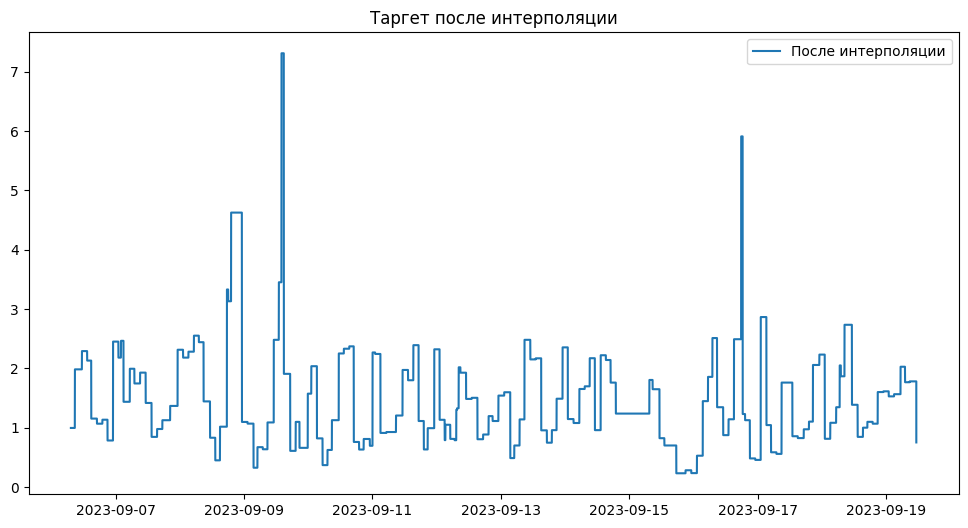

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data["timestamp"], merged_data["target"], label="После интерполяции")
plt.title("Таргет после интерполяции")
plt.legend()
plt.show()


In [12]:
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19119 entries, 0 to 19118
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   Unnamed: 0              19119 non-null  int64              
 1   timestamp               19119 non-null  datetime64[ns, UTC]
 2   ppm1                    18965 non-null  float64            
 3   temp1                   18965 non-null  float64            
 4   temp2                   18965 non-null  float64            
 5   ppm2                    18965 non-null  float64            
 6   gas_opening1            18965 non-null  float64            
 7   press1                  18965 non-null  float64            
 8   rotationspeed1          18965 non-null  float64            
 9   press3                  18965 non-null  float64            
 10  temp3                   18965 non-null  float64            
 11  press2                  18965 non-null  f

In [13]:
merged_data.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1,target
0,3017,2023-09-06 07:17:00+00:00,1195.45435,831.816895,847.329819,8.844165,80.359341,0.853588,0.0,111.25,...,2.195150,99.441243,53.25,59.571020,852.998840,NaN,4.497253,-0.283300,-1.029347,0.9948
1,3018,2023-09-06 07:18:00+00:00,1039.89673,833.734787,852.541763,9.774559,80.295139,0.852684,0.0,73.50,...,2.194935,99.433971,52.25,57.666964,855.704742,NaN,5.705383,-0.243801,-0.541925,0.9948
2,3019,2023-09-06 07:19:00+00:00,1051.79541,835.776062,853.039108,10.449957,79.938873,0.850875,0.0,87.50,...,2.194719,99.426700,53.50,56.417607,859.920242,NaN,7.153229,-0.196984,-0.067268,0.9948
3,3020,2023-09-06 07:20:00+00:00,1058.19043,837.580017,858.191376,9.647234,80.025679,3.050854,0.0,125.00,...,2.194504,99.419428,54.00,56.993423,861.524811,NaN,8.314209,-0.167878,0.386957,0.9948
4,3021,2023-09-06 07:21:00+00:00,1300.44700,836.155853,869.958008,7.783049,79.962383,3.268772,0.0,129.75,...,2.194289,99.412157,54.50,58.700148,859.587967,NaN,9.306335,-0.105204,0.856819,0.9948


In [14]:
merged_data = merged_data.drop(columns=["Unnamed: 0"])


**Посмотрим на пропуски**

In [15]:
missing_values = merged_data.isnull().sum()
print("Признаки с пропусками:\n", missing_values[missing_values > 0])


Признаки с пропусками:
 ppm1                        154
temp1                       154
temp2                       154
ppm2                        154
gas_opening1                154
press1                      154
rotationspeed1              154
press3                      154
temp3                       154
press2                      154
press4                      154
temp4                       154
electric_ampere1            154
speed1                      154
press5                      154
electric_consumption2       154
press6                      154
speed2                      154
electric_consumption3       154
inlet_pressure1             154
press7                      154
gas_consumption1            154
press8                      154
press9                      154
electric_consumption4       154
electric_consumption5       154
press10                     154
sito1                       154
moisture1                   154
ALM1                        154
CaO1            

In [16]:
missing_ratio = (missing_values / len(merged_data)).sort_values(ascending=False)
print("\nДоля пропусков в признаках:\n", missing_ratio[missing_ratio > 0])



Доля пропусков в признаках:
 target_ffill              0.690517
coeffs_current1           0.163711
electric_ampere_delta1    0.159841
ppm1                      0.008055
press1                    0.008055
temp1                     0.008055
temp2                     0.008055
ppm2                      0.008055
temp4                     0.008055
temp3                     0.008055
press2                    0.008055
press4                    0.008055
speed1                    0.008055
gas_opening1              0.008055
rotationspeed1            0.008055
press3                    0.008055
CaO1                      0.008055
press5                    0.008055
electric_ampere1          0.008055
electric_consumption2     0.008055
inlet_pressure1           0.008055
press6                    0.008055
speed2                    0.008055
electric_consumption3     0.008055
press9                    0.008055
electric_consumption4     0.008055
electric_consumption5     0.008055
press10                  

**Пропуски:**

- Пропуски присутствуют во многих колонках, но их количество невелико (до 0.8% для большинства признаков). Исключение составляет колонка target_ffill, где доля пропусков составляет 69%, что делает её нерелевантной.

**Корреляция и очистка признаков:**

- Множество признаков требуют анализа на предмет их значимости (корреляция с target). Некоторые признаки, такие как Unnamed: 0, являются техническими и могут быть удалены.


In [17]:
merged_data = merged_data.drop(columns=["target_ffill"])


**Для колонок с менее чем 10% пропусков можно заполнить значения, mean для непрерывных данных**

In [18]:
merged_data.fillna(merged_data.mean(), inplace=True)


**Признаки с минимальной вариативностью не добавляют ценности модели, поэтому удалим их**

In [19]:
numeric_columns = merged_data.select_dtypes(include=["float64", "int64"])

low_variance_features = numeric_columns.std()[numeric_columns.std() < 0.01].index

merged_data = merged_data.drop(columns=low_variance_features)

print(f"Удалено {len(low_variance_features)} признаков с низкой вариативностью.")


Удалено 0 признаков с низкой вариативностью.


**Проверим корреляцию с target**

In [20]:
correlation_with_target = numeric_columns.corr()["target"].sort_values(ascending=False)

print("Наиболее значимые признаки с корреляцией к таргету:")
print(correlation_with_target.head(10))

print("\nНаименее значимые признаки с корреляцией к таргету:")
print(correlation_with_target.tail(10))


Наиболее значимые признаки с корреляцией к таргету:
target             1.000000
LSF2               0.383422
CaO2               0.269928
temp5              0.213942
sito1              0.192051
ALM2               0.182647
temp1              0.136754
inlet_pressure1    0.100354
CaO1               0.073943
temp3              0.071753
Name: target, dtype: float64

Наименее значимые признаки с корреляцией к таргету:
press6                  -0.301917
speed1                  -0.304167
electric_consumption5   -0.310458
electric_consumption3   -0.313986
electric_consumption2   -0.316033
press2                  -0.318657
electric_consumption4   -0.335142
press7                  -0.336511
speed2                  -0.336747
temp2                   -0.394810
Name: target, dtype: float64


In [21]:
merged_data_copy = merged_data.copy()

In [22]:
low_corr_features = correlation_with_target[abs(correlation_with_target) < 0.1].index
merged_data = merged_data.drop(columns=low_corr_features)

print(f"Удалено {len(low_corr_features)} признаков с низкой корреляцией.")


Удалено 17 признаков с низкой корреляцией.


In [23]:
print("Оставшиеся признаки после фильтрации:")
print(merged_data.columns)

print(f"Размер датасета после фильтрации: {merged_data.shape}")


Оставшиеся признаки после фильтрации:
Index(['timestamp', 'temp1', 'temp2', 'gas_opening1', 'press1', 'press3',
       'press2', 'temp4', 'electric_ampere1', 'speed1', 'press5',
       'electric_consumption2', 'press6', 'speed2', 'electric_consumption3',
       'inlet_pressure1', 'press7', 'press8', 'press9',
       'electric_consumption4', 'electric_consumption5', 'press10', 'sito1',
       'ALM2', 'CaO2', 'LSF2', 'electric_ampere2', 'electric_ampere3', 'temp5',
       'target'],
      dtype='object')
Размер датасета после фильтрации: (19119, 30)


In [24]:
remaining_features = merged_data.columns
print("Оставшиеся признаки после фильтрации:")
for feature in remaining_features:
    print(f"- {feature}")

print(f"\nВсего признаков (включая target): {len(remaining_features)}")


Оставшиеся признаки после фильтрации:
- timestamp
- temp1
- temp2
- gas_opening1
- press1
- press3
- press2
- temp4
- electric_ampere1
- speed1
- press5
- electric_consumption2
- press6
- speed2
- electric_consumption3
- inlet_pressure1
- press7
- press8
- press9
- electric_consumption4
- electric_consumption5
- press10
- sito1
- ALM2
- CaO2
- LSF2
- electric_ampere2
- electric_ampere3
- temp5
- target

Всего признаков (включая target): 30


### Описание признаков

- **timestamp**: Временная метка, указывающая на момент сбора данных.
  
- **temp1**: Температура, измеренная на первом участке оборудования.
  
- **temp2**: Температура, измеренная на втором участке оборудования.
  
- **gas_opening1**: Показатель открытия газового клапана (в процентах или другой относительной единице).
  
- **press1**: Давление на первом участке оборудования.
  
- **press3**: Давление на третьем участке оборудования.
  
- **press2**: Давление на втором участке оборудования.
  
- **temp4**: Температура, измеренная на четвёртом участке оборудования.
  
- **electric_ampere1**: Потребление электрического тока (в амперах) на первом участке оборудования.
  
- **speed1**: Скорость вращения или движения на первом участке оборудования.
  
- **press5**: Давление на пятом участке оборудования.
  
- **electric_consumption2**: Потребление электроэнергии (в кВт·ч или другой единице) на втором участке.
  
- **press6**: Давление на шестом участке оборудования.
  
- **speed2**: Скорость вращения или движения на втором участке оборудования.
  
- **electric_consumption3**: Потребление электроэнергии (в кВт·ч или другой единице) на третьем участке.

- **inlet_pressure1**: Давление на входе первого участка оборудования.
  
- **press7**: Давление на седьмом участке оборудования.
  
- **press8**: Давление на восьмом участке оборудования.
  
- **press9**: Давление на девятом участке оборудования.
  
- **electric_consumption4**: Потребление электроэнергии (в кВт·ч или другой единице) на четвёртом участке.
  
- **electric_consumption5**: Потребление электроэнергии (в кВт·ч или другой единице) на пятом участке.
  
- **press10**: Давление на десятом участке оборудования.
  
- **sito1**: Показатель ситовой фракции (содержание частиц определённого размера) на первом участке.
  
- **ALM2**: Показатель содержания оксидов алюминия (Al₂O₃) на втором участке.

- **CaO2**: Показатель содержания оксида кальция (CaO) на втором участке.

- **LSF2**: Коэффициент насыщения известью (Lime Saturation Factor) на втором участке.

- **electric_ampere2**: Потребление электрического тока (в амперах) на втором участке оборудования.
  
- **electric_ampere3**: Потребление электрического тока (в амперах) на третьем участке оборудования.

- **temp5**: Температура, измеренная на пятом участке оборудования.

- **target**: Целевая переменная, представляющая химический показатель в клинкере.



**Добавим временные лаги:**

In [25]:
lag_features = [1, 2, 3] 
for lag in lag_features:
    merged_data[f"target_lag_{lag}"] = merged_data["target"].shift(lag)

key_features = ["temp1", "press1", "gas_opening1"]
for feature in key_features:
    for lag in lag_features:
        merged_data[f"{feature}_lag_{lag}"] = merged_data[feature].shift(lag)

merged_data = merged_data.dropna().reset_index(drop=True)

print("Добавлены временные лаги.")


Добавлены временные лаги.


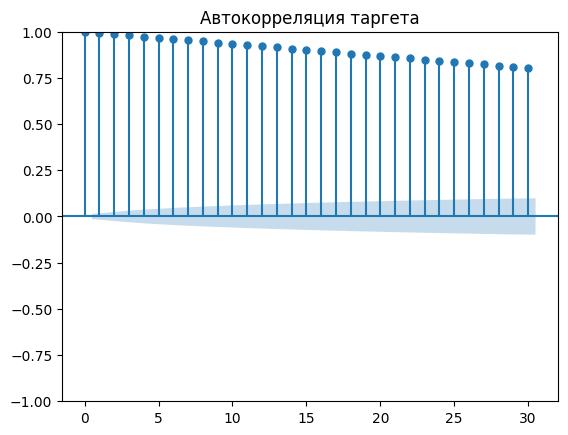

In [26]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(merged_data["target"], lags=30)
plt.title("Автокорреляция таргета")
plt.show()


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(merged_data["target"], model="additive", period=24)  

merged_data["target_trend"] = result.trend
merged_data["target_seasonal"] = result.seasonal
merged_data["target_residual"] = result.resid

print("Выделены тренды и сезонности.")


Выделены тренды и сезонности.


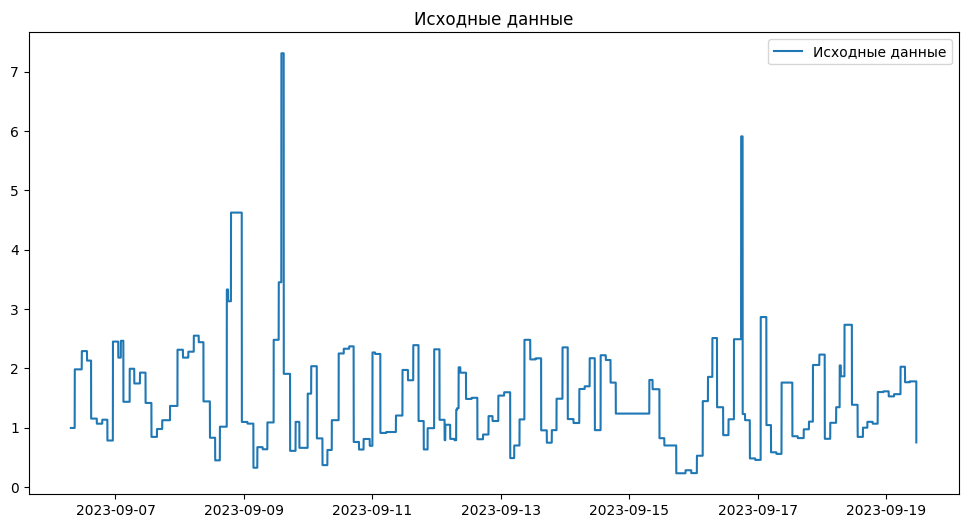

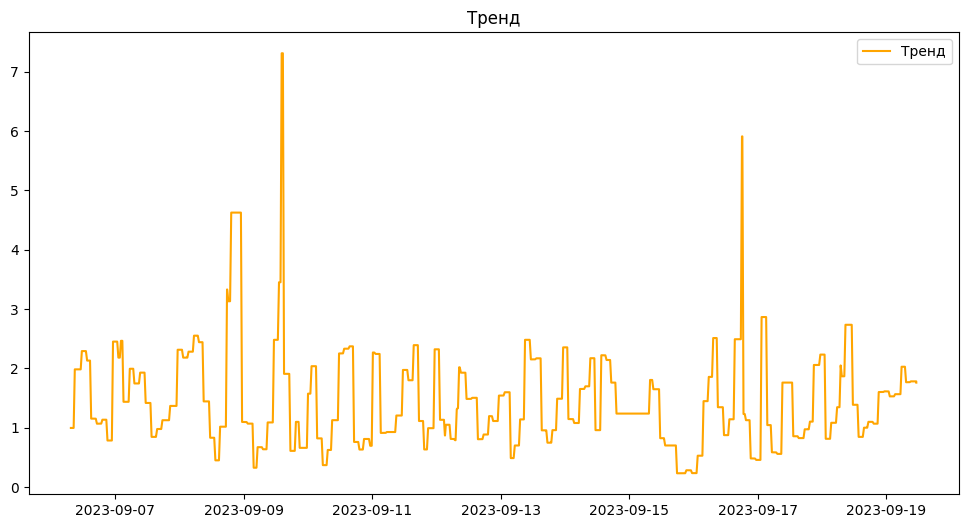

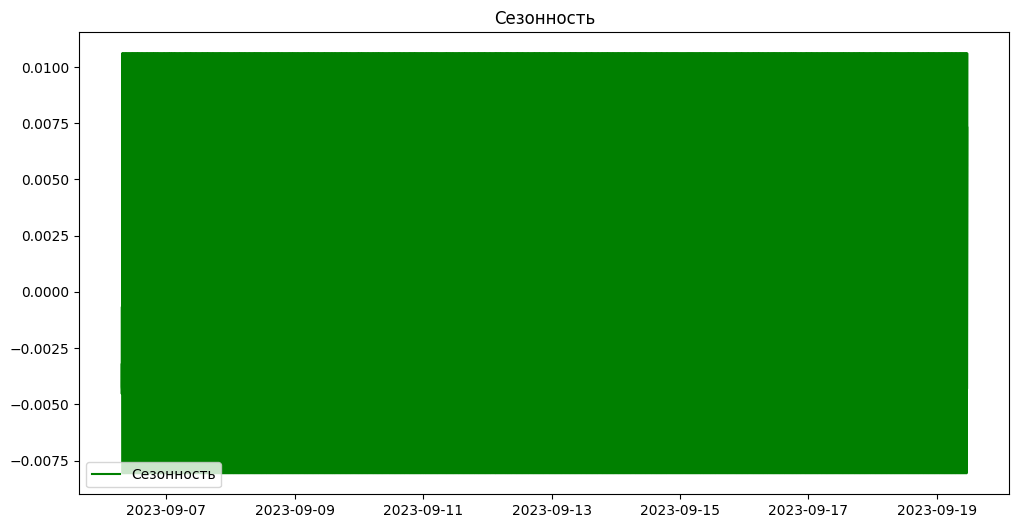

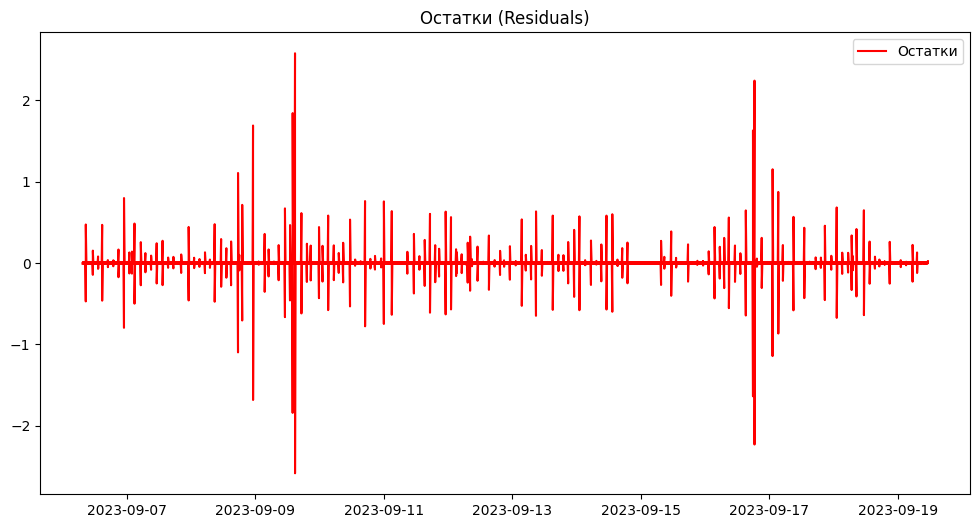

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data["timestamp"], merged_data["target"], label="Исходные данные")
plt.title("Исходные данные")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data["timestamp"], merged_data["target_trend"], label="Тренд", color="orange")
plt.title("Тренд")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data["timestamp"], merged_data["target_seasonal"], label="Сезонность", color="green")
plt.title("Сезонность")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data["timestamp"], merged_data["target_residual"], label="Остатки", color="red")
plt.title("Остатки (Residuals)")
plt.legend()
plt.show()


Среднее значение остатков: 0.00000
Стандартное отклонение остатков: 0.13326


<Figure size 1000x600 with 0 Axes>

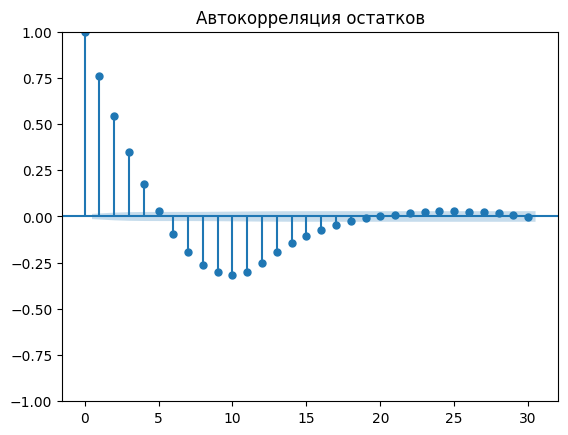

In [29]:
residuals_mean = merged_data["target_residual"].mean()
residuals_std = merged_data["target_residual"].std()

print(f"Среднее значение остатков: {residuals_mean:.5f}")
print(f"Стандартное отклонение остатков: {residuals_std:.5f}")

plt.figure(figsize=(10, 6))
plot_acf(merged_data["target_residual"].dropna(), lags=30)
plt.title("Автокорреляция остатков")
plt.show()

- Среднее значение равно нулю, что идеально. Это говорит о том, что тренды и сезонность были корректно удалены, и остатки не имеют систематического смещения.

- Небольшое стандартное отклонение говорит о том, что разброс остатков относительно мал. Это также положительный показатель, так как большая часть вариаций в данных объясняется трендом и сезонностью, а остатки представляют только "шум".

- Наличие значительной автокорреляции на первых нескольких лагах указывает на то, что в остатках присутствует некоторая зависимость.
После 5–6 лагов автокорреляция становится близкой к нулю, что означает, что большая часть зависимости была учтена.

## Задача №1

  **Построить виртуальный датчик (ВД) показателя в таргете, который сможет расчитывать значение в настоящий момент времени,  что существенно снизит нагрузку на лабораторию и даст возможность оператору быстрее реагировать на изменения в процессе.**

Модель будем выбирать, исходя из следующих критериев:

- Скорость предсказания (т.к расчет должен выполняться "в реальном времени", модель должна быть быстрой в прогнозировании)

- Простота и интерпретируемость (модель была достаточно понятной для оператора, чтобы объяснить, как конкретные параметры влияют на target)

- Гибкость и качество (модель должна быть достаточно мощной, чтобы выявлять сложные зависимости между признаками и целевым параметром)



С учетом задачи и данных, было принято начать с градиентного бустинга (LightGBM или CatBoost), т.к:

- Учитывает нелинейные зависимости
- Работает быстро
- Не требует сложной предобработки данных
- Легче в настройке, чем нейронные сети


Train MAE: 0.0022, Test MAE: 0.0057
Train RMSE: 0.0057, Test RMSE: 0.0330

Важность признаков:
                  Feature  Importance
42        target_residual        4732
28           target_lag_1        2027
40           target_trend        2002
29           target_lag_2         728
34           press1_lag_1         498
14        inlet_pressure1         495
30           target_lag_3         488
20                press10         407
37     gas_opening1_lag_1         401
41        target_seasonal         395
1                   temp2         375
31            temp1_lag_1         373
4                  press3         334
24                   LSF2         329
23                   CaO2         320
38     gas_opening1_lag_2         319
26       electric_ampere3         296
17                 press9         296
27                  temp5         293
7        electric_ampere1         289
16                 press8         285
32            temp1_lag_2         278
12                 speed2      

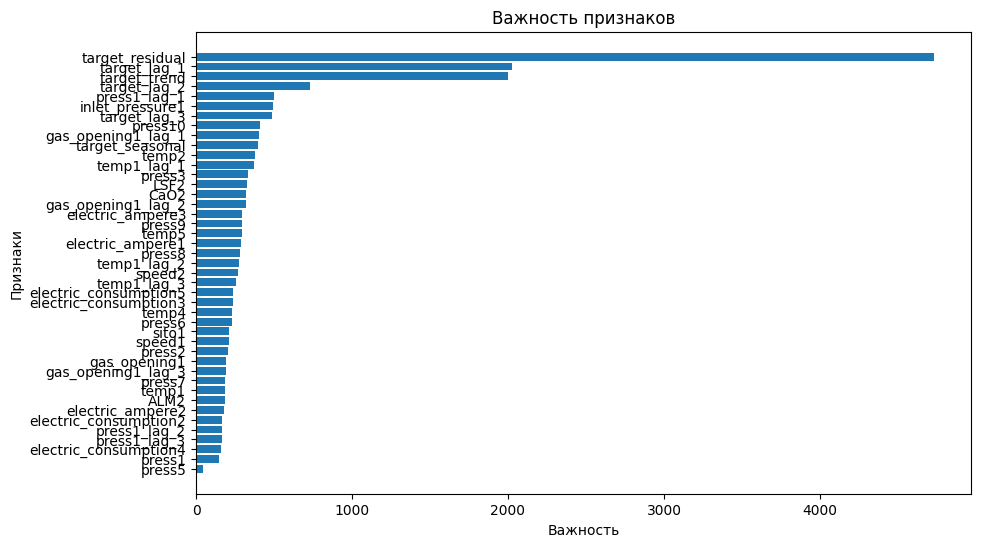

In [30]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = merged_data.drop(columns=["target", "timestamp"])
target = merged_data["target"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LGBMRegressor(
    n_estimators=1000,      
    learning_rate=0.05,     
    max_depth=7,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    random_state=42,
    verbose=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  
    eval_metric="mae"            
)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

feature_importances = pd.DataFrame({"Feature": features.columns, "Importance": model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("\nВажность признаков:")
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.title("Важность признаков")
plt.gca().invert_yaxis()
plt.show()


**Результаты:**

Train MAE: 0.0022, Test MAE: 0.0057

Train RMSE: 0.0057, Test RMSE: 0.0330

Высокая точность на тренировочной выборке. Но видно явное переобучение и так же много признаков с низкой и нулевой важностью.



**Попробуем:**
- Исключить признаки с низкой важностью
- Добавить кросс-валидацию
- Добавить регулязацию

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score

feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

low_importance_features = feature_importances[feature_importances["Importance"] <= 10]["Feature"]
X_train = X_train.drop(columns=low_importance_features)
X_test = X_test.drop(columns=low_importance_features)

optimized_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=100,
    lambda_l1=1.0,
    lambda_l2=1.0,
    random_state=42
)

cv_scores = -cross_val_score(optimized_model, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
print(f"\nСредний MAE на кросс-валидации: {cv_scores.mean():.4f}")

optimized_model.fit(X_train, y_train)

y_pred_train = optimized_model.predict(X_train)
y_pred_test = optimized_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Оптимизированная модель -> Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Оптимизированная модель -> Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")




Средний MAE на кросс-валидации: 0.0163
Оптимизированная модель -> Train MAE: 0.0125, Test MAE: 0.0133
Оптимизированная модель -> Train RMSE: 0.0596, Test RMSE: 0.0605


**В итоге:**

- Уменьшили переобучение (после оптимизации разрыв между Train и Test MAE/RMSE стал значительно меньше, что указывает на стабильную модель)
- Важность признаков(оставили важные признаки)
- Средний MAE = 0.0163 на кросс-валидации говорит о том, что модель хорошо обобщает данные на валидационных подвыборках.


## Задача №2
**Построить прогнозную модель, которая на горизонте в 15 минут может установить значение таргета.**

- Создадим таргет, который будем предсказывать `target_t+15`
- Добавим временные лаги таргета
- Добавим временные признаки
- Создадим новые статистические признаки
- Вычислим остатки
- Добавим разности (дифференцирование)
- Добавим кумулятивную сумму
- Добавим экспоненциальное сглаживание
- Добавим флаг критической зоны
- Оптимизируем гиперпараметры модели CatBoost


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END depth=4, iterations=500, learning_rate=0.01;, score=-0.260 total time=   0.5s
[CV 2/3] END depth=4, iterations=500, learning_rate=0.01;, score=-0.082 total time=   0.4s
[CV 3/3] END depth=4, iterations=500, learning_rate=0.01;, score=-0.137 total time=   0.4s
[CV 1/3] END depth=4, iterations=500, learning_rate=0.05;, score=-0.265 total time=   0.4s
[CV 2/3] END depth=4, iterations=500, learning_rate=0.05;, score=-0.077 total time=   0.4s
[CV 3/3] END depth=4, iterations=500, learning_rate=0.05;, score=-0.129 total time=   0.4s
[CV 1/3] END depth=4, iterations=500, learning_rate=0.1;, score=-0.276 total time=   0.4s
[CV 2/3] END depth=4, iterations=500, learning_rate=0.1;, score=-0.081 total time=   0.4s
[CV 3/3] END depth=4, iterations=500, learning_rate=0.1;, score=-0.148 total time=   0.4s
[CV 1/3] END depth=4, iterations=1000, learning_rate=0.01;, score=-0.250 total time=   0.8s
[CV 2/3] END depth=4, iteration

/home/alex/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.01}
0:	learn: 0.8593241	total: 1.06ms	remaining: 1.06s
100:	learn: 0.4625279	total: 90ms	remaining: 801ms
200:	learn: 0.3303142	total: 178ms	remaining: 707ms
300:	learn: 0.2670327	total: 266ms	remaining: 619ms
400:	learn: 0.2269099	total: 355ms	remaining: 530ms
500:	learn: 0.2009744	total: 443ms	remaining: 441ms
600:	learn: 0.1856873	total: 531ms	remaining: 353ms
700:	learn: 0.1767990	total: 619ms	remaining: 264ms
800:	learn: 0.1703145	total: 706ms	remaining: 175ms
900:	learn: 0.1654251	total: 793ms	remaining: 87.1ms
999:	learn: 0.1611241	total: 879ms	remaining: 0us
MAE (средняя абсолютная ошибка): 0.0842
RMSE (корень из среднеквадратичной ошибки): 0.1885
Critical Zone MAE: 0.0902


/home/alex/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


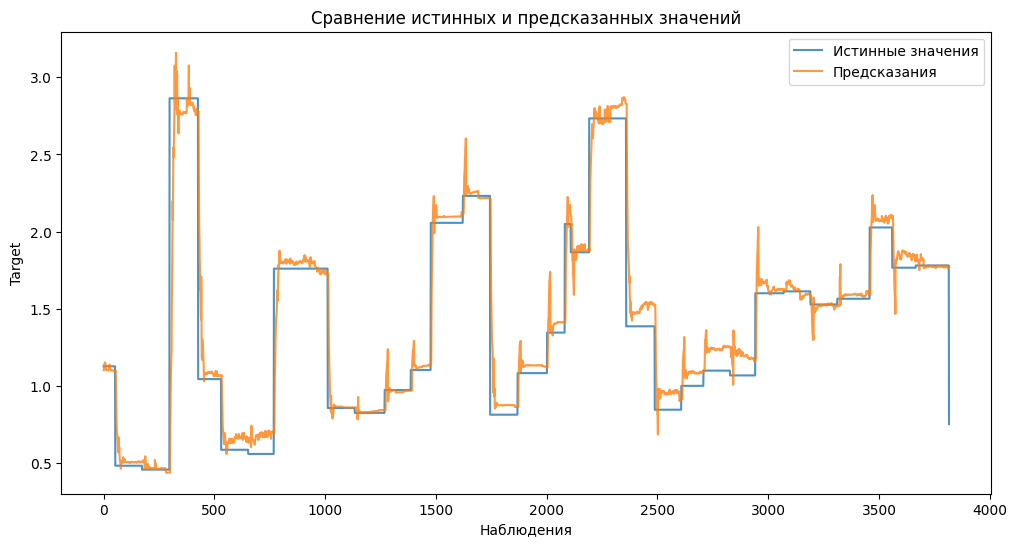

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np

merged_data['target_t+15'] = merged_data['target'].shift(-15)

for lag in range(1, 11): 
    merged_data[f'target_lag_{lag}'] = merged_data['target'].shift(lag)

merged_data['hour'] = merged_data['timestamp'].dt.hour
merged_data['day_of_week'] = merged_data['timestamp'].dt.dayofweek

for window in [5, 15, 20]:
    merged_data[f'rolling_mean_{window}'] = merged_data['target'].rolling(window=window).mean()
    merged_data[f'rolling_std_{window}'] = merged_data['target'].rolling(window=window).std()

merged_data['rolling_mean_5'] = merged_data['target'].rolling(window=5).mean()
merged_data['residuals_5'] = merged_data['target'] - merged_data['rolling_mean_5']

merged_data['diff_1'] = merged_data['target'].diff(1)
merged_data['diff_2'] = merged_data['target'].diff(2)

merged_data['cumulative_sum'] = merged_data['target'].cumsum()

merged_data['exp_smoothing'] = merged_data['target'].ewm(span=5).mean()

merged_data['is_critical'] = ((merged_data['target'] < 1) | (merged_data['target'] > 2)).astype(int)

data_for_prediction = merged_data.dropna()

feature_columns = [col for col in data_for_prediction.columns if col not in ['timestamp', 'target', 'target_t+15']]

X = data_for_prediction[feature_columns]
y = data_for_prediction['target_t+15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

catboost_model = CatBoostRegressor(
    random_seed=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=3
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, verbose=100)

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE (средняя абсолютная ошибка): {mae:.4f}")
print(f"RMSE (корень из среднеквадратичной ошибки): {rmse:.4f}")

critical_zones = (y_test < 1) | (y_test > 2)
critical_mae = mean_absolute_error(y_test[critical_zones], y_pred[critical_zones])
print(f"Critical Zone MAE: {critical_mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Истинные значения', alpha=0.8)
plt.plot(y_pred, label='Предсказания', alpha=0.8)
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('Наблюдения')
plt.ylabel('Target')
plt.legend()
plt.show()


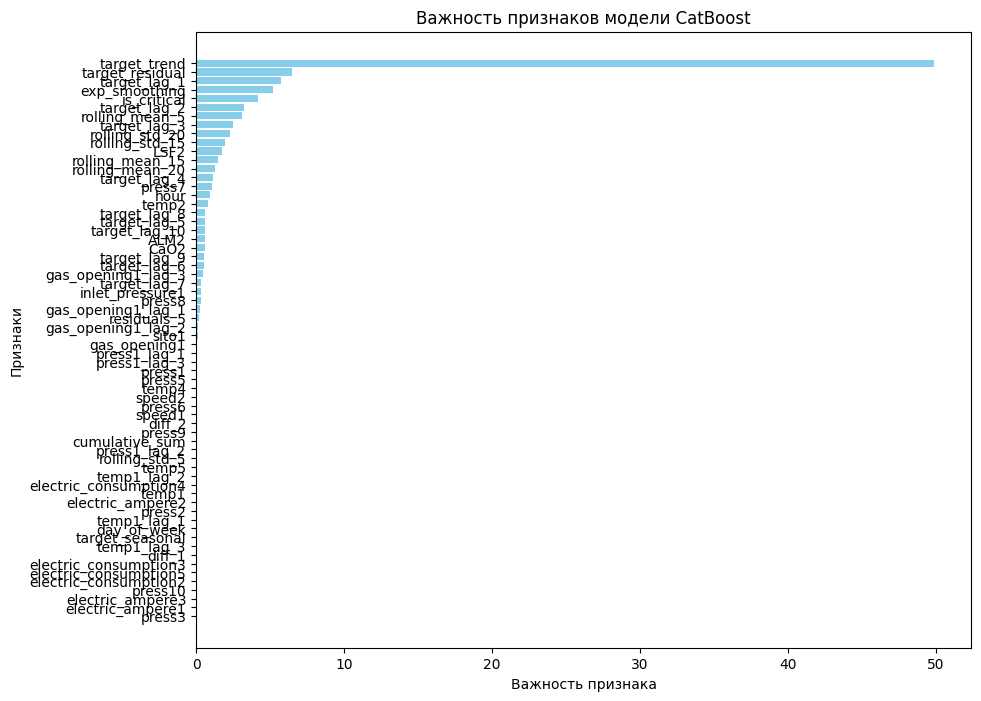

In [33]:
feature_importances = best_model.get_feature_importance(prettified=True)
feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.gca().invert_yaxis()  
plt.show()


**Итоги:**

- MAE (0.0878)
- RMSE (0.1891)
- Critical Zone MAE (0.0938) 
- Модель хорошо справляется с задачей предсказания таргета на 15 минут вперёд.
- Она даёт низкие значения ошибок как в общем случае, так и в критических зонах, что говорит о её стабильности и точности.
- Скорость обучения(Несмотря на 1000 итераций, время обучения остаётся приемлемым. Это связано с эффективностью CatBoost и ограниченной глубиной дерева)

## Задача №3
**Построить модель, которая может определить значение таргета в случае изменения показателя gas_consumption1 на шаг 150 (текущее значение + 150) в последующие 15 минут.**

Колонка 'gas_consumption1' восстановлена из merged_data_copy.
Колонка 'gas_consumption1_modified' успешно добавлена в merged_data.
Колонка 'gas_consumption1_modified' добавлена в data_for_prediction.
Признак 'gas_consumption1_modified' успешно добавлен в feature_columns.
0:	learn: 0.8591255	total: 2.52ms	remaining: 2.52s
100:	learn: 0.4381162	total: 169ms	remaining: 1.5s


/tmp/ipykernel_16038/2302106319.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_prediction['gas_consumption1_modified'] = merged_data['gas_consumption1_modified']


200:	learn: 0.2799029	total: 334ms	remaining: 1.33s
300:	learn: 0.2134937	total: 500ms	remaining: 1.16s
400:	learn: 0.1849371	total: 666ms	remaining: 994ms
500:	learn: 0.1708768	total: 831ms	remaining: 827ms
600:	learn: 0.1619627	total: 994ms	remaining: 660ms
700:	learn: 0.1550799	total: 1.16s	remaining: 494ms
800:	learn: 0.1496622	total: 1.32s	remaining: 328ms
900:	learn: 0.1449631	total: 1.49s	remaining: 163ms
999:	learn: 0.1406298	total: 1.65s	remaining: 0us
MAE (средняя абсолютная ошибка): 0.0892
RMSE (корень из среднеквадратичной ошибки): 0.1924
Critical Zone MAE: 0.0942


/home/alex/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


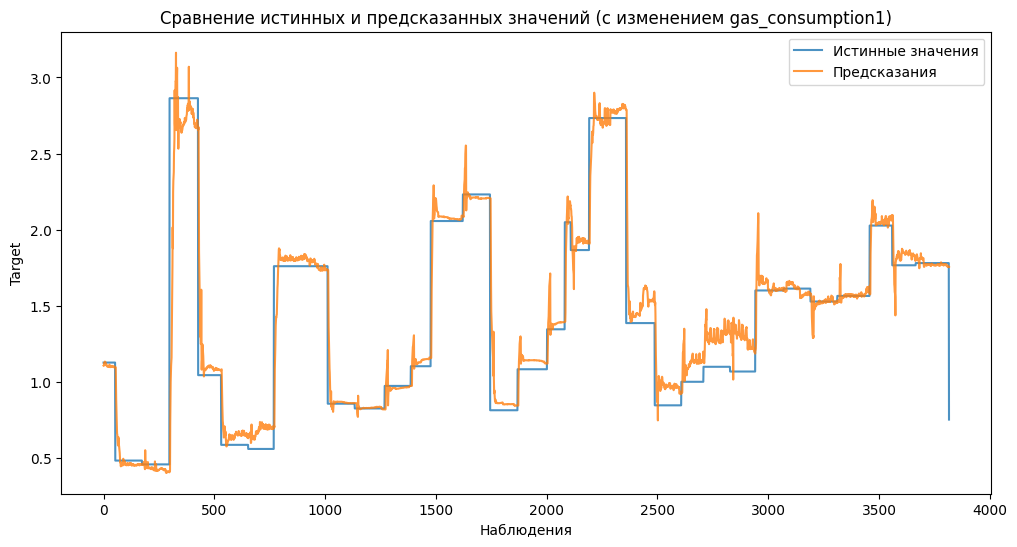

Важность признака 'gas_consumption1_modified': 0.29


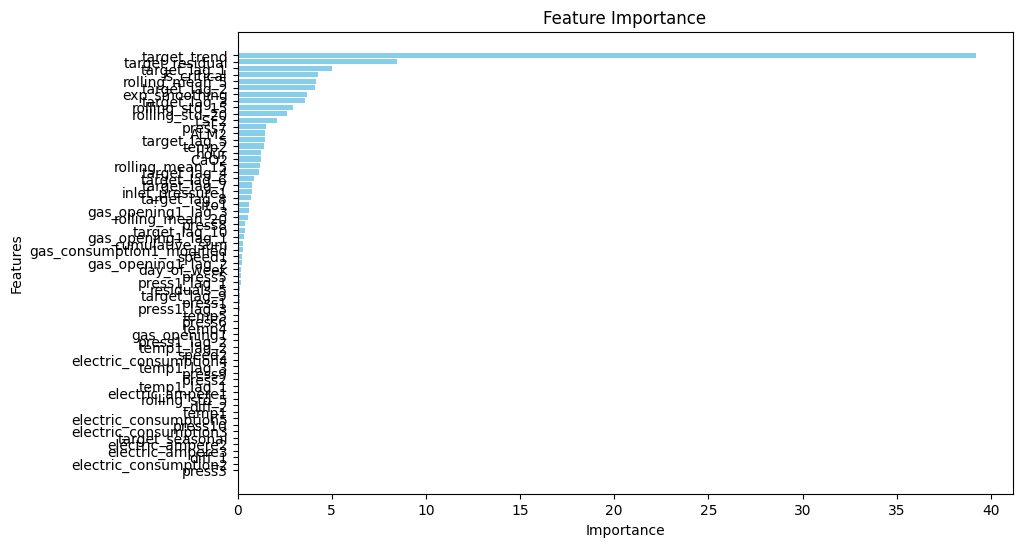

In [ ]:
if 'gas_consumption1' not in merged_data.columns:
    if 'gas_consumption1' in merged_data_copy.columns:
        merged_data['gas_consumption1'] = merged_data_copy['gas_consumption1']
        print("Колонка 'gas_consumption1' восстановлена из merged_data_copy.")
    else:
        raise KeyError("Колонка 'gas_consumption1' отсутствует как в merged_data, так и в merged_data_copy!")

merged_data['gas_consumption1_modified'] = merged_data['gas_consumption1'] + 150
print("Колонка 'gas_consumption1_modified' успешно добавлена в merged_data.")


if 'gas_consumption1_modified' not in data_for_prediction.columns:
    data_for_prediction['gas_consumption1_modified'] = merged_data['gas_consumption1_modified']
    print("Колонка 'gas_consumption1_modified' добавлена в data_for_prediction.")
else:
    print("Колонка 'gas_consumption1_modified' уже присутствует в data_for_prediction.")


feature_columns = [col for col in data_for_prediction.columns 
                   if col not in ['timestamp', 'target', 'target_t+15', 'gas_consumption1']]

if 'gas_consumption1_modified' in feature_columns:
    print("Признак 'gas_consumption1_modified' успешно добавлен в feature_columns.")
else:
    print("Ошибка: 'gas_consumption1_modified' отсутствует в feature_columns!")


X = data_for_prediction[feature_columns]
y = data_for_prediction['target_t+15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


best_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    random_seed=42,
    verbose=100
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE (средняя абсолютная ошибка): {mae:.4f}")
print(f"RMSE (корень из среднеквадратичной ошибки): {rmse:.4f}")

critical_zones = (y_test < 1) | (y_test > 2)
critical_mae = mean_absolute_error(y_test[critical_zones], y_pred[critical_zones])
print(f"Critical Zone MAE: {critical_mae:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Истинные значения', alpha=0.8)
plt.plot(y_pred, label='Предсказания', alpha=0.8)
plt.title('Сравнение истинных и предсказанных значений (с изменением gas_consumption1)')
plt.xlabel('Наблюдения')
plt.ylabel('Target')
plt.legend()
plt.show()


feature_importances = best_model.get_feature_importance()
for feature, importance in zip(feature_columns, feature_importances):
    if feature == 'gas_consumption1_modified':
        print(f"Важность признака 'gas_consumption1_modified': {importance:.2f}")

importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


**Итоги:**
- Признак gas_consumption1_modified действительно влияет на предсказания, но его важность невелика.
- Изменение gas_consumption1 не оказывает сильного влияния на модель, так как она больше зависит от других признаков, связанных с таргетом.
- Модель из прошлого задания справляется с задачей даже после модификации данных, что говорит о её устойчивости и хорошей настройке.